# Feature Engineering: Distances between two opinions/evaluations

### Yifei Huang
Email: yifei@caltech.edu

## Introduction: the Motivation

Different from traditional performance evaluation where mangers evaluate their subordinates, 360-degree performance appraisal asks everyone in the team to evaluate everyone else. This process generates very rich information about the team.

Essentially, every individual in the team is a human sensor. In the first level, information generated by them tell us about individual performances. In the second level, it also inform about the sensors themselves: how each one views his/her teammates. For example, to which extent one's evaluation deviates from the consensus.

In this note, I extract features in the second level. For an individual in the team, I measure the degree to which his/her evaluations are different from the team's consensus. The team's consensus is measured by averaging everyone's evaluations. In addition, I also measure the extent to which a team member's evaluation differs from the team leader's.

I will explore predictive power of these new features. In particular, to which extent these features can help in predicting promotion outcomes in the team.

## Defining the Distance Function

How to measure the difference between two evaluations? There are well grounded mathematical foundation for this. An evaluation naturally defines an ordering over the set of objects being evaluated. We measure distance between two orderings by computing the proportion of agreement in pairwise comparisons. Specifically, if there are n people being evaluated, then there are n(n-1)/2 pairs of people. For each pair of people, we check wether the two evaluations agree upon which person is better. The distance is measured by the proportion of agreement in the n(n-1)/2 pairwise comparisons.

In [16]:
# Import packages
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from itertools import combinations

In [17]:
def distance(eval_1, eval_2):
    '''
    Computes the distance, which measures the degree of agreement, between two evaluations on a set of objects. 
    In the context, the set of objects are people in a team. 
    An evaluation consists ratings (i.e., scores) on everyone in the team. Higher score means better performance.
    How to compute the distance: 
    If there are n people being evaluated, then there are n(n-1)/2 pairs of people.
    For each pair of people, we check wether the two evaluations agree on which person is better. 
    The distance is measured by the proportion of agreement in the n(n-1)/2 pairwise comparisons.
    @param eval_1: the first evaluation, which is a dictionary: {object1: rating1, object2:rating2, ...}.
    @param eval_2: the second evaluation.
    '''
    common_keys = list(set(eval_1.keys()) & set(eval_2.keys())) # the set of common ratees
    pairs = [p for p in combinations(common_keys, 2)] # all possible pairwise comparisons
    comparison = {p: None for p in pairs}
    # looping over pairs to count the number of agreed pairs
    for p in pairs:
        c1 = eval_1[p[0]] - eval_1[p[1]]
        c2 = eval_2[p[0]] - eval_2[p[1]]
        if c1 * c2 >= 0:
            comparison[p] = 1
        else:
            comparison[p] = 0
    # computing distances
    if len(comparison) != 0:
        distance = sum(comparison.values())/float(len(comparison))
        n_pairs = len(comparison)
        return {'distance': distance, 'n_pairs': n_pairs}
    # the case when denominator is zero
    else: 
        print "Pairwise comparison impossible for one occasion."
        return None
    

In [18]:
# An Example of distance(eval_1, eval_2):
e1 = {'Alice':6.9, 'Bob':7.3, 'Chris': 8.2}
e2 = {'Alice':8.6, 'Bob':9.9, 'Chris': 9.1, 'David': 8.8}
print "Pairwise comparisons:", [p for p in combinations(['Alice', 'Bob', 'Chris'], 2)]
print "Agreed: Bob is better than Alice, and Chris is better than Alice."
print "Disagreed: Between Bob and Chris, who is better?"
distance(e1, e2)

Pairwise comparisons: [('Alice', 'Bob'), ('Alice', 'Chris'), ('Bob', 'Chris')]
Agreed: Bob is better than Alice, and Chris is better than Alice.
Disagreed: Between Bob and Chris, who is better?


{'distance': 0.6666666666666666, 'n_pairs': 3}

## Generating Distances for the Dataset

In [19]:
# Import the dataset of 360-degree appraisal
data = pd.read_csv('ratings.csv')
print "Dimensions of the dataset:", data.shape
print "Column names:", data.columns.values

Dimensions of the dataset: (7964, 10)
Column names: ['rateecode' 'ratercode' 'yr' 'dep' 'rank_rater' 'rank_ratee' 'perfscore'
 'self' 'peer' 'rater_head']


In [20]:
# Units of analysis: Teams
teams = data.groupby(['yr', 'dep'])
team_names = [name for name, group in teams]
print "The number of teams:", len(teams)
print "\nEach team refers to a department in a given year. Listing the teams:"
print "(yr,dep):", team_names


The number of teams: 32

Each team refers to a department in a given year. Listing the teams:
(yr,dep): [(10, 1), (10, 2), (10, 3), (10, 5), (10, 6), (10, 7), (11, 1), (11, 2), (11, 3), (11, 5), (11, 6), (11, 7), (12, 1), (12, 2), (12, 3), (12, 5), (12, 6), (12, 7), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7)]


In [21]:
# Generating distance measures for every person
distances = list()
for name, team in teams: # looping over teams, the basic units of analysis
    orderings = list()
    team_raters = team.groupby('ratercode')
    # putting every rater's evaluation into a dictionary
    for rater, group in team_raters:
        eval_rater = {row['rateecode']: row['perfscore'] for index, row in group.iterrows()}
        orderings.append({'rater': rater, 'ordering': eval_rater})
    # computing concensus ordering by averaging over every rater
    team_ratees = team.groupby('rateecode')
    team_means = team_ratees['perfscore'].mean()
    concensus = {list(team_means.index)[i]:list(team_means.values)[i] for i in range(len(team_means.index))}
    # putting the team leader's ordering into a seperate dictionary
    team_leader = team[team['rater_head'].isin([1])]
    leader = {row['rateecode']: row['perfscore'] for index, row in team_leader.iterrows()}
    # computing distances for the team
    for p in orderings:
        d_concensus = distance(p['ordering'], concensus)
        d_leader = distance(p['ordering'], leader)
        if d_concensus != None and d_leader != None:
            distances.append({'code': p['rater'], 'distance_concensus': d_concensus['distance'], 
                              'n_pairs_concensus': d_concensus['n_pairs'], 
                             'distance_leader': d_leader['distance'],
                             'n_pairs_leader': d_leader['n_pairs']})
        else:
            print "The code of the individual who caused this error:", p['rater']
            
print "\nNote: This individual was evaluated but did not rate anyone. Our analysis will not be affected by this."

Pairwise comparison impossible for one occasion.
Pairwise comparison impossible for one occasion.
The code of the individual who caused this error: 12622

Note: This individual was evaluated but did not rate anyone. Our analysis will not be affected by this.


In [22]:
# Constructing the dataframe of distances, writing to CSV
df_distances = pd.DataFrame(distances)
pd.DataFrame.to_csv(df_distances, 'distances.csv', index = False)
print df_distances.shape
df_distances.head(5)

(453, 5)


,code,distance_concensus,distance_leader,n_pairs_concensus,n_pairs_leader
0,10101,0.915033,1.000000,153,153
1,10102,0.777778,0.764706,153,153
2,10103,0.895425,0.869281,153,153
3,10104,0.836601,0.797386,153,153
4,10105,0.823529,0.843137,153,153


## Some Brief Visualizations

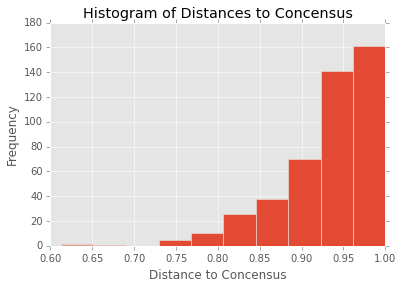

In [9]:
plt.hist(df_distances['distance_concensus'])
plt.xlabel('Distance to Concensus')
plt.ylabel('Frequency')
plt.title('Histogram of Distances to Concensus')

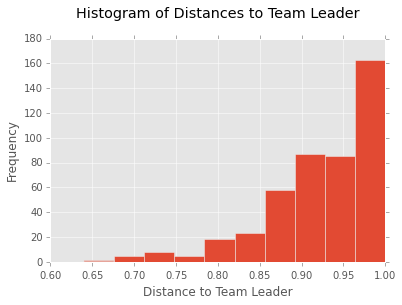

In [10]:
plt.hist(df_distances['distance_leader'])
plt.xlabel('Distance to Team Leader')
plt.ylabel('Frequency')
plt.title('Histogram of Distances to Team Leader\n')
plt.show()

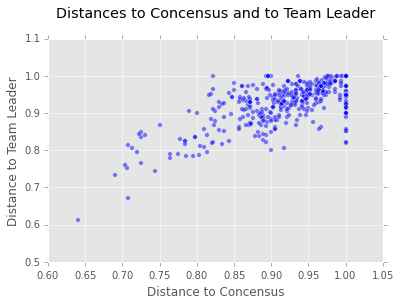

In [11]:
plt.scatter(df_distances['distance_leader'], df_distances['distance_concensus'],  alpha=0.5)
plt.xlabel('Distance to Concensus')
plt.ylabel('Distance to Team Leader')
plt.title('Distances to Concensus and to Team Leader\n')
plt.show()

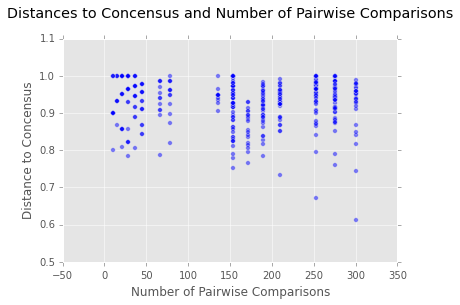

In [12]:
plt.scatter(df_distances['n_pairs_concensus'], df_distances['distance_concensus'], alpha=0.5)
plt.xlabel('Number of Pairwise Comparisons')
plt.ylabel('Distance to Concensus')
plt.title('Distances to Concensus and Number of Pairwise Comparisons\n')
plt.show()

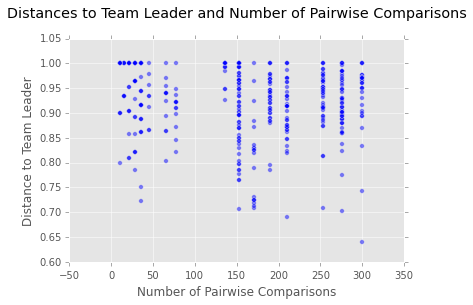

In [13]:
plt.scatter(df_distances['n_pairs_leader'], df_distances['distance_leader'], alpha=0.5)
plt.xlabel('Number of Pairwise Comparisons')
plt.ylabel('Distance to Team Leader')
plt.title('Distances to Team Leader and Number of Pairwise Comparisons\n')
plt.show()